In [10]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.random import normal as randn, multivariate_normal as randmn
import pandas as pd
from scipy.io.wavfile import read
from sklearn.preprocessing import StandardScaler
from collections.abc import Iterable

from algorithms.score_based import *
from algorithms.fast_contrastive_change_point import compute_test_stat_ftal
from algorithms.kliep import compute_test_stat_kliep
from algorithms.m_statistic import compute_test_stat_mmd
import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Auxiliary function and CENSREC-1-C SNR-20 dataset preprocessing

In [11]:
def compute_delays_false_alarms(runs, S_list, threshold, tau):
    delays = []
    false_alarms = 0
    not_detected = 0

    for i in range(runs):

        S = S_list[i]
        res = np.ma.flatnotmasked_edges(np.ma.masked_array(S, S <= threshold))
        if isinstance(res, Iterable):
            imin, _ = res
            if imin - tau[i] < 0:
                print(imin, i)
                false_alarms += 1
            else:
                delays.append(imin - tau[i])
        else:
            not_detected +=1

    if not_detected == runs:
        return 0, 0, 0, not_detected

    delays = np.array(delays)
    mean_delay = np.round(delays.mean(), 1)
    std_delay = np.round(delays.std(), 1)

    return false_alarms, mean_delay, std_delay, not_detected

In [12]:
# Read the data
input_data = read('data/CENSREC/MAH_N1_SNR20.wav')
audio = input_data[1]

In [13]:
# Data preprocessing

# Scaling
scaler = StandardScaler()
audio_scaled = scaler.fit_transform(audio.reshape(-1, 1))
audio_scaled = audio_scaled.reshape(-1)

# Reduce the data, averaging over 10 values
bandwidth = 10
N = audio_scaled.shape[0] // bandwidth

data = np.empty(0)

for t in range(N):
        
    data = np.append(data, np.mean(audio_scaled[bandwidth * t : bandwidth * (t + 1)]))
    
print(data.shape[0])

change_points = [410, 2835, 6147, 7891, 10347, 12974, 15967, 18682, 21128, 23620]
change_points = np.array(change_points)
print(change_points)



24801
[  410  2835  6147  7891 10347 12974 15967 18682 21128 23620]


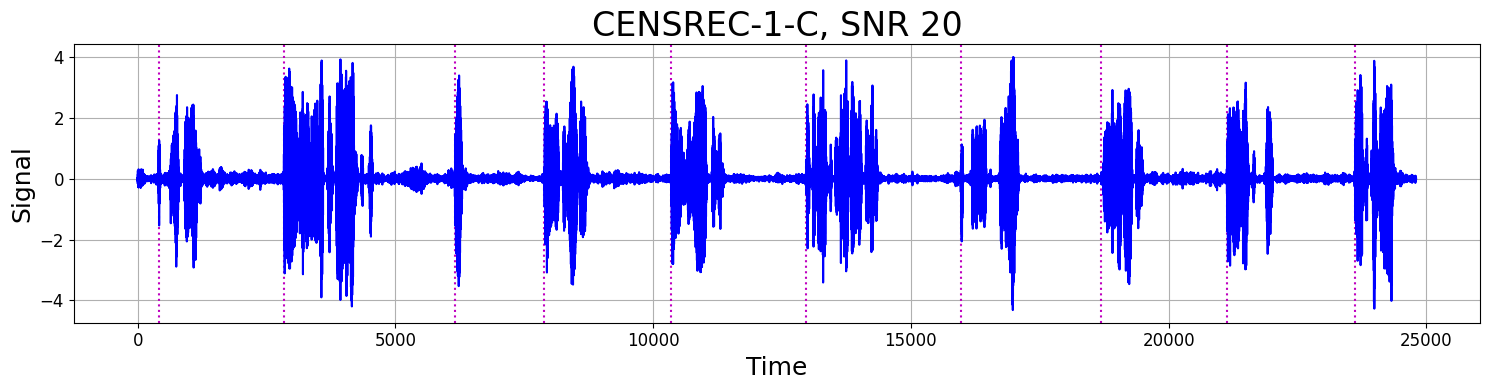

In [14]:
plt.figure(figsize=(15, 4))

for c in change_points:
    plt.axvline(c, c='m', ls=':')

plt.plot(np.arange(data.shape[0]), data, c='b')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title(label='CENSREC-1-C, SNR 20', fontsize=24)
plt.xlabel('Time', fontsize=18)
plt.ylabel('Signal', fontsize=18)
plt.grid()
plt.tight_layout()



In [15]:
# Split the data into the stationary part, validation part, and test part

# Stationary part: three parts of the time series without the change points.
# Used to tune the threshold
#
data_stationary = [data[:390]]

# Validation part: a part with several change points to tune the hyperparameters
val_start = [300, 2720, 6050, 7800]
val_end = [500, 2920, 6250, 8000]
data_val = [data[val_start[i]:val_end[i]] for i in range(len(val_start))]

# Test part: check the performance of the procedures
test_start = [10250, 12870, 15850, 18580, 21020, 23520]
test_end = [10450, 13070, 16050, 18780, 21220, 23720]
data_test = [data[test_start[i]:test_end[i]] for i in range(len(test_start))]

In [16]:
change_points

array([  410,  2835,  6147,  7891, 10347, 12974, 15967, 18682, 21128,
       23620])

In [17]:
# Change points on the validation set
change_points_val = change_points[change_points < val_end[-1]] - val_start
change_points_val = change_points_val[change_points_val > 0]
print('Validation change points:', change_points_val)

# Change points on the test set
change_points_test = change_points[change_points < test_end[-1]] 
change_points_test = change_points_test[change_points_test > test_start[0]] - test_start
print('Test change points:', change_points_test)

# Validation change points for plot
cpval = []
l = 0
for i in range(len(change_points_val)):
    cpval += [change_points_val[i] + l]
    l += data_val[0].shape[0]

# Validation data for plot
val_for_plot = np.hstack([data_val[i] for i in range(len(change_points_val))])


# Test change points for plot

cptest = []
l = 0
for i in range(len(change_points_test)):
    cptest += [change_points_test[i] + l]
    l += data_test[0].shape[0]

# Test data for plot
test_for_plot = np.hstack([data_test[i] for i in range(len(change_points_test))])


data_with_cps_for_plot = np.hstack([val_for_plot, test_for_plot])
cps = np.append(cpval, np.array(cptest)+800)
print('All change points: ', cps)

Validation change points: [110 115  97  91]
Test change points: [ 97 104 117 102 108 100]
All change points:  [ 110  315  497  691  897 1104 1317 1502 1708 1900]


### Score-based quadratic 

In [84]:
# The list of hyperparameters
eta_list = [0.05, 0.1,  0.15, 0.2]
lambda_list = [0.5, 0.8, 1]
alpha_list = [1e-5, 1e-4, 1e-3]

# Change points on the validation set
change_points_val = change_points[change_points < val_end[-1]] - val_start
change_points_val = change_points_val[change_points_val > 0]
print('Validation change points:', change_points_val)
    
dim=1
for eta in eta_list:
    for l in lambda_list:
        for a in alpha_list:
            #----------------------------------------------------
            # Step 1: tuning the threshold on the stationary part
            #----------------------------------------------------

            # manually


            #----------------------------------------------------
            # Step 2: detect changes on the validation part
            #----------------------------------------------------

            # Initialization of the test statistic
            S_q_list = np.empty((len(data_val), data_val[0].shape[0]))

            for i in range(len(change_points_val)):
                model = ChangePointDetector(d_dim=dim*2, x_dim=dim, lambda_=l, alpha=a, basis=PolyBasis(2, dim))
                new_S_q, _ = model.run(data_val[i].reshape(-1, 1), eta)  
                S_q_list[i] = new_S_q

            
            for z in [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 5e-5, 1]:
                false_alarms_q, dd_mean_q, dd_std_q, not_detected_q = compute_delays_false_alarms(len(data_val), S_q_list, z, change_points_val)
                print(f'Score-based quadratic, threshold={z}, eta={eta}, lambda = {l}, alpha={a}', '. FA:', false_alarms_q,\
                                '; DD:', dd_mean_q, '±',dd_std_q,\
                                '; ND:', not_detected_q)


Validation change points: [110 115  97  91]
106 0
Score-based quadratic, threshold=1e-05, eta=0.05, lambda = 0.5, alpha=1e-05 . FA: 1 ; DD: 7.3 ± 6.2 ; ND: 0
106 0
Score-based quadratic, threshold=0.0001, eta=0.05, lambda = 0.5, alpha=1e-05 . FA: 1 ; DD: 7.3 ± 6.2 ; ND: 0
106 0
Score-based quadratic, threshold=0.001, eta=0.05, lambda = 0.5, alpha=1e-05 . FA: 1 ; DD: 7.3 ± 6.2 ; ND: 0
106 0
Score-based quadratic, threshold=0.01, eta=0.05, lambda = 0.5, alpha=1e-05 . FA: 1 ; DD: 7.3 ± 6.2 ; ND: 0
108 0
Score-based quadratic, threshold=0.1, eta=0.05, lambda = 0.5, alpha=1e-05 . FA: 1 ; DD: 8.3 ± 6.3 ; ND: 0
106 0
Score-based quadratic, threshold=5e-05, eta=0.05, lambda = 0.5, alpha=1e-05 . FA: 1 ; DD: 7.3 ± 6.2 ; ND: 0
109 0
Score-based quadratic, threshold=1, eta=0.05, lambda = 0.5, alpha=1e-05 . FA: 1 ; DD: 8.7 ± 6.2 ; ND: 0
102 0
Score-based quadratic, threshold=1e-05, eta=0.05, lambda = 0.5, alpha=0.0001 . FA: 1 ; DD: 4.0 ± 2.9 ; ND: 0
102 0
Score-based quadratic, threshold=0.0001, et

In [24]:
# The list of hyperparameters
eta_list = [0.15]
lambda_list = [1]
alpha_list = [1e-4]

# Change points on the validation set
change_points_val = change_points[change_points < val_end[-1]] - val_start
change_points_val = change_points_val[change_points_val > 0]
print('Validation change points:', change_points_val)
    
dim=1
for eta in eta_list:
    for l in lambda_list:
        for a in alpha_list:

            z = 1e-5
            #----------------------------------------------------
            # Step 2: detect changes on the validation part
            #----------------------------------------------------

            # Initialization of the test statistic

            S_q_list = np.empty((len(data_val), data_val[0].shape[0]))

            for i in range(len(change_points_val)):
                model = ChangePointDetector(d_dim=dim*2, x_dim=dim, lambda_=l, alpha=a, basis=PolyBasis(2, dim))
                new_S_q, _ = model.run(data_val[i].reshape(-1, 1), eta)  
                S_q_list[i] = new_S_q

            false_alarms_q, dd_mean_q, dd_std_q, not_detected_q = compute_delays_false_alarms(len(data_val), S_q_list, z, change_points_val)
            print(f'Score-based quadratic, threshold={z}, eta={eta}, lambda = {l}, alpha={a}', '. FA:', false_alarms_q,\
                            '; DD:', dd_mean_q, '±',dd_std_q,\
                            '; ND:', not_detected_q)

s_q_train = np.hstack(S_q_list)

Validation change points: [110 115  97  91]
102 0
Score-based quadratic, threshold=1e-05, eta=0.15, lambda = 1, alpha=0.0001 . FA: 1 ; DD: 3.3 ± 3.4 ; ND: 0


In [26]:

#----------------------------------------------------
# Step 3: detect changes on the test part
#----------------------------------------------------

# Change points on the test set
change_points_test = change_points[change_points < test_end[-1]] 
change_points_test = change_points_test[change_points_test > test_start[0]] - test_start
print('Test change points:', change_points_test)

# Initialization of the test statistic
S_list = np.empty((len(change_points_test), data_test[0].shape[0]))
dim=1


eta = 0.15
l = 1
a = 1e-4
z = 1e-5


for i in range(len(change_points_test)):
    model = ChangePointDetector(d_dim=dim*2, x_dim=dim, lambda_=l, alpha=a, basis=PolyBasis(2, dim))
    new_S_q, _ = model.run(data_test[i].reshape(-1, 1), eta)      
    S_list[i] = new_S_q

false_alarms_q, dd_mean_q, dd_std_q, not_detected_q = compute_delays_false_alarms(len(change_points_test), S_list, z, change_points_test)
print(f'Score-based quadratic, eta={eta}, lambda = {l}, alpha={a}', '. FA:', false_alarms_q,\
                '; DD:', dd_mean_q, '±', dd_std_q,\
                '; ND:', not_detected_q)

s_q_test = np.hstack(S_list)


Test change points: [ 97 104 117 102 108 100]
Score-based quadratic, eta=0.15, lambda = 1, alpha=0.0001 . FA: 0 ; DD: 10.7 ± 19.0 ; ND: 0


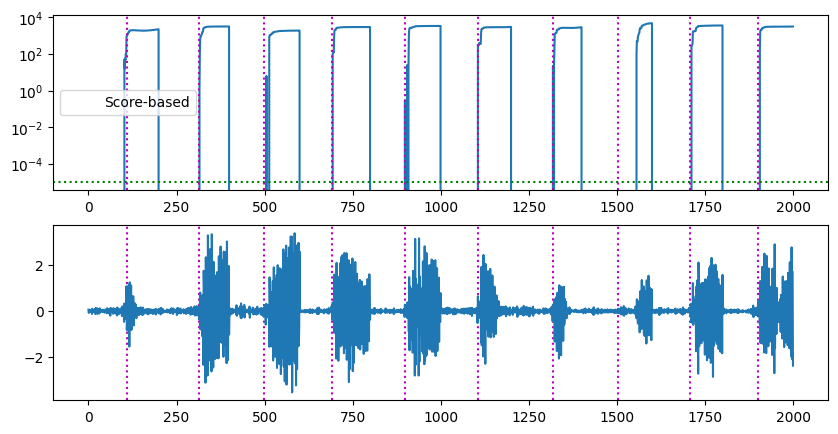

In [30]:
S_q = np.append(s_q_train, s_q_test)
f, ax = plt.subplots(2, 1, figsize=(10, 5))
ax[0].plot(S_q)
ax[0].set_yscale('log')
ax[0].axhline(z, c='g', ls=':')
for c in cps:
    ax[0].axvline(c, c='m', ls=':')
    ax[1].axvline(c, c='m', ls=':')
ax[0].plot(0, lw=0, label="Score-based")
ax[1].plot(data_with_cps_for_plot)
ax[0].legend()
plt.show()


### Fast contrastive + hermite

In [9]:
# The list of hyperparameters
p_list = [ 3, 4, 5, 6, 7, 8]
beta_list = [0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 2.5, 5, 7]

# Change points on the validation set
change_points_val = change_points[change_points < val_end[-1]] - val_start
change_points_val = change_points_val[change_points_val > 0]
print('Validation change points:', change_points_val)
    
dim=1
for p in p_list:
    for b in beta_list:
        #----------------------------------------------------
        # Step 1: tuning the threshold on the stationary part
        #----------------------------------------------------

        S_stationary = np.empty(0)
        for ds in data_stationary:
            S, _ = compute_test_stat_ftal(ds, p, beta=b, design='hermite')
            S_stationary = np.append(S_stationary, S)
            
        # Set the threshold as the maximal value on the stationary part
        z = np.maximum(np.max(S_stationary), 0.01)
        zs = np.linspace(z, z+3, 5)
        print('threshold =', z)

        #----------------------------------------------------
        # Step 2: detect changes on the validation part
        #----------------------------------------------------

        # Initialization of the test statistic
        S_ftal_list = np.empty((len(data_val), data_val[0].shape[0]))

        for i in range(len(change_points_val)):
            new_S_ftal, _ = compute_test_stat_ftal(data_val[i], p, beta=b, design='hermite')
            S_ftal_list[i] = new_S_ftal


        false_alarms_ftal, dd_mean_ftal, dd_std_ftal, not_detected_ftal = compute_delays_false_alarms(len(data_val), S_ftal_list, z, change_points_val)
        print(f'FTAL, beta = {b}, p={p}', '. Number of false alarms:', false_alarms_ftal,\
                '; average delay:', dd_mean_ftal, '±', dd_std_ftal,\
                '; non-detected:', not_detected_ftal)


Validation change points: [110 115  97  91]
threshold = 4.3352840290146
[113, 122, 117, 102]
FTAL, beta = 0.005, p=3 . Number of false alarms: 0 ; average delay: 10.25 ± 6.2998 ; non-detected: 0
threshold = 4.212490808079666
[112, 122, 118, 102]
FTAL, beta = 0.01, p=3 . Number of false alarms: 0 ; average delay: 10.25 ± 6.9776 ; non-detected: 0
threshold = 4.266083721692388
[113, 122, 119, 102]
FTAL, beta = 0.02, p=3 . Number of false alarms: 0 ; average delay: 10.75 ± 7.0843 ; non-detected: 0
threshold = 4.32640255485702
[114, 123, 120, 102]
FTAL, beta = 0.05, p=3 . Number of false alarms: 0 ; average delay: 11.5 ± 7.0887 ; non-detected: 0
threshold = 4.363571229163296
[115, 124, 125, 104]
FTAL, beta = 0.1, p=3 . Number of false alarms: 0 ; average delay: 13.75 ± 8.6999 ; non-detected: 0
threshold = 4.313415563712596
[118, 127, 128, 108]
FTAL, beta = 0.2, p=3 . Number of false alarms: 0 ; average delay: 17.0 ± 8.6891 ; non-detected: 0
threshold = 3.4749554660446003
[117, 124, 127, 106

In [31]:
# The list of hyperparameters
p_list = [5]
beta_list = [5]
z =  0.5361798574510446

# Change points on the validation set
change_points_val = change_points[change_points < val_end[-1]] - val_start
change_points_val = change_points_val[change_points_val > 0]
print('Validation change points:', change_points_val)
    
dim=1
for p in p_list:
    for b in beta_list:

        #----------------------------------------------------
        # Step 2: detect changes on the validation part
        #----------------------------------------------------
        S_ftal_list = np.empty((len(data_val), data_val[0].shape[0]))

        for i in range(len(change_points_val)):
            new_S_ftal, _ = compute_test_stat_ftal(data_val[i], p, beta=b, design='hermite')
            S_ftal_list[i] = new_S_ftal


        false_alarms_ftal, dd_mean_ftal, dd_std_ftal, not_detected_ftal = compute_delays_false_alarms(len(data_val), S_ftal_list, z, change_points_val)
        print(f'FTAL, beta = {b}, p={p}', '. Number of false alarms:', false_alarms_ftal,\
                '; average delay:', dd_mean_ftal, '±', dd_std_ftal,\
                '; non-detected:', not_detected_ftal)

s_ftal_train = np.hstack(S_ftal_list)     

Validation change points: [110 115  97  91]
FTAL, beta = 5, p=5 . Number of false alarms: 0 ; average delay: 6.0 ± 6.5 ; non-detected: 0


In [35]:
#----------------------------------------------------
# Step 3: detect changes on the test part
#----------------------------------------------------

# Change points on the test set
change_points_test = change_points[change_points < test_end[-1]] 
change_points_test = change_points_test[change_points_test > test_start[0]] - test_start
print('Test change points:', change_points_test)
    
p=5
b =5
z = 0.5361798574510446

# Initialization of the test statistic
S_ftal_list = np.empty((len(data_test), data_test[0].shape[0]))

for i in range(len(change_points_test)):
    new_S_ftal, _ = compute_test_stat_ftal(data_test[i], p, beta=b,\
                                                    design='hermite')
    S_ftal_list[i] = new_S_ftal

fa_ftal, dd_mean_ftal, dd_std_ftal, not_detected_ftal = compute_delays_false_alarms(len(data_test), S_ftal_list, z, change_points_test)

print(f'FTAL, beta = {b}, p={p}', '. Number of false alarms:', fa_ftal,\
    '; average delay:', dd_mean_ftal, '±', dd_std_ftal,\
    '; non-detected:', not_detected_ftal)

s_ftal_test = np.hstack(S_ftal_list)

Test change points: [ 97 104 117 102 108 100]
FTAL, beta = 5, p=5 . Number of false alarms: 0 ; average delay: 18.0 ± 19.0 ; non-detected: 0


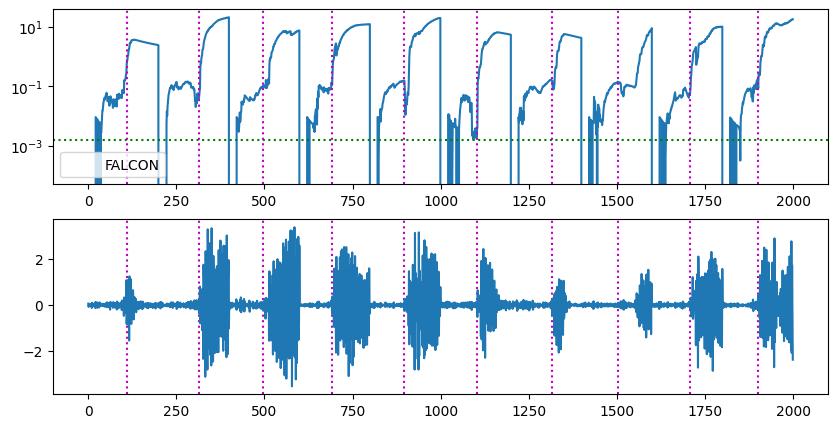

In [52]:
S_ftal = np.append(s_ftal_train, s_ftal_test)
f, ax = plt.subplots(2, 1, figsize=(10, 5))
ax[0].plot(S_ftal)
ax[0].set_yscale('log')
ax[0].axhline(z, c='g', ls=':')
for c in cps:
    ax[0].axvline(c, c='m', ls=':')
    ax[1].axvline(c, c='m', ls=':')
ax[0].plot(0, lw=0, label="FALCON")
ax[1].plot(data_with_cps_for_plot)
ax[0].legend()
plt.show()


### KLIEP

In [130]:
# The list of hyperparameters
sigma_list = [0.01, 0.02, 0.025, 0.05, 0.075, 0.1, 0.2, 0.25, 0.5, 0.75, 1, 1.5, 2]

# Change points on the validation set
change_points_val = change_points[change_points < val_end[-1]] - val_start
change_points_val = change_points_val[change_points_val > 0]
print('Validation change points:', change_points_val)
    
    
for sigma in sigma_list:
    
    #----------------------------------------------------
    # Step 1: tuning the threshold on the stationary part
    #----------------------------------------------------

    S_stationary = np.empty(0)
    for ds in data_stationary:
        S, _ = compute_test_stat_kliep(ds, window_size=50, sigma=sigma)
        S_stationary = np.append(S_stationary, S)
        
    # Set the threshold as the maximal value on the stationary part
    z = np.round(np.max(S_stationary), 4)
    print('sigma =', sigma, ', threshold =', z)
    
    #----------------------------------------------------
    # Step 2: detect changes on the validation part
    #----------------------------------------------------

    # Initialization of the test statistic
    S_kliep_list = np.empty((len(data_val), data_val[0].shape[0]))

    for i in range(len(change_points_val)):
        new_S_kliep, _ = compute_test_stat_kliep(data_val[i], window_size=50, sigma=sigma)
        S_kliep_list[i] = new_S_kliep

    fa_kliep, dd_mean_kliep, dd_std_kliep, not_detected_kliep = compute_delays_false_alarms(len(data_val), S_kliep_list, z, change_points_val)

    print(f'KlIEP, sigma = {sigma}', '. Number of false alarms:', fa_kliep,\
        '; average delay:', dd_mean_kliep, '±', dd_std_kliep,\
        '; non-detected:', not_detected_kliep)
    

Validation change points: [110 115  97  91]
sigma = 0.01 , threshold = 80.588
KlIEP, sigma = 0.01 . Number of false alarms: 0 ; average delay: 10.2 ± 8.2 ; non-detected: 0
sigma = 0.02 , threshold = 49.1694
105 0
KlIEP, sigma = 0.02 . Number of false alarms: 1 ; average delay: 11.0 ± 9.4 ; non-detected: 0
sigma = 0.025 , threshold = 39.9454
102 0
112 1
KlIEP, sigma = 0.025 . Number of false alarms: 2 ; average delay: 16.0 ± 6.0 ; non-detected: 0
sigma = 0.05 , threshold = 32.3739
107 0
KlIEP, sigma = 0.05 . Number of false alarms: 1 ; average delay: 12.0 ± 8.3 ; non-detected: 0
sigma = 0.075 , threshold = 29.2741
107 0
KlIEP, sigma = 0.075 . Number of false alarms: 1 ; average delay: 11.7 ± 8.7 ; non-detected: 0
sigma = 0.1 , threshold = 27.5725
107 0
KlIEP, sigma = 0.1 . Number of false alarms: 1 ; average delay: 12.0 ± 8.3 ; non-detected: 0
sigma = 0.2 , threshold = 13.1063
109 0
KlIEP, sigma = 0.2 . Number of false alarms: 1 ; average delay: 11.7 ± 7.8 ; non-detected: 0
sigma = 0.25

In [39]:
#----------------------------------------------------
# Step 2: detect changes on the validation part
#----------------------------------------------------

# The list of hyperparameters
sigma = 0.01
z= 80.588

# Change points on the validation set
change_points_val = change_points[change_points < val_end[-1]] - val_start
change_points_val = change_points_val[change_points_val > 0]
print('Validation change points:', change_points_val)

# Initialization of the test statistic
S_kliep_list = np.empty((len(data_val), data_val[0].shape[0]))

for i in range(len(change_points_val)):
    new_S_kliep, _ = compute_test_stat_kliep(data_val[i], window_size=50, sigma=sigma)
    S_kliep_list[i] = new_S_kliep

fa_kliep, dd_mean_kliep, dd_std_kliep, not_detected_kliep = compute_delays_false_alarms(len(data_val), S_kliep_list, z, change_points_val)

print(f'KlIEP, sigma = {sigma}', '. Number of false alarms:', fa_kliep,\
    '; average delay:', dd_mean_kliep, '±', dd_std_kliep,\
    '; non-detected:', not_detected_kliep)

s_kliep_train = np.hstack(S_kliep_list)

Validation change points: [110 115  97  91]
KlIEP, sigma = 0.01 . Number of false alarms: 0 ; average delay: 10.2 ± 8.2 ; non-detected: 0


In [41]:
#----------------------------------------------------
# Step 3: detect changes on the test part
#----------------------------------------------------

# Change points on the test set
change_points_test = change_points[change_points < test_end[-1]] 
change_points_test = change_points_test[change_points_test > test_start[0]] - test_start
print('Test change points:', change_points_test)
    
sigma = 0.01
z = 80.588

# Initialization of the test statistic
S_kliep_list = np.empty((len(data_test), data_test[0].shape[0]))

for i in range(len(change_points_test)):
    new_S_kliep, _ = compute_test_stat_kliep(data_test[i], window_size=50, sigma=sigma)
    S_kliep_list[i] = new_S_kliep

fa_kliep, dd_mean_kliep, dd_std_kliep, not_detected_kliep = compute_delays_false_alarms(len(data_test), S_kliep_list, z, change_points_test)

print(f'KlIEP, sigma = {sigma}', '. Number of false alarms:', fa_kliep,\
    '; average delay:', dd_mean_kliep, '±', dd_std_kliep,\
    '; non-detected:', not_detected_kliep)

s_kliep_test = np.hstack(S_kliep_list)

Test change points: [ 97 104 117 102 108 100]
KlIEP, sigma = 0.01 . Number of false alarms: 0 ; average delay: 20.3 ± 14.2 ; non-detected: 0


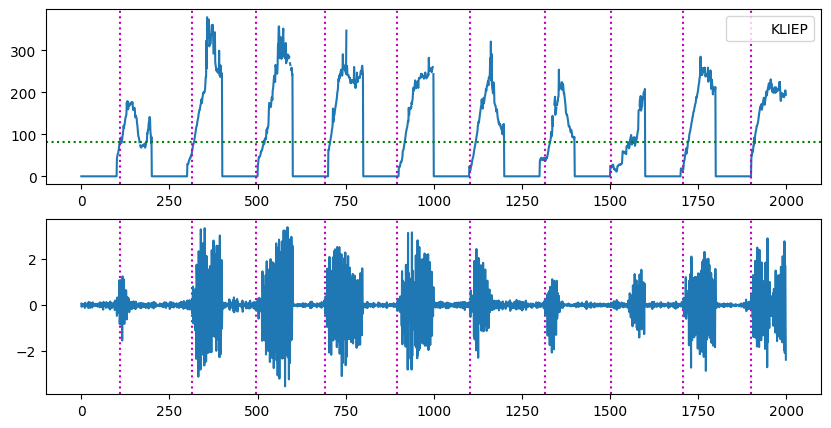

In [43]:
S_kliep = np.append(s_kliep_train, s_kliep_test)
f, ax = plt.subplots(2, 1, figsize=(10, 5))
ax[0].plot(S_kliep)
ax[0].axhline(z, c='g', ls=':')
for c in cps:
    ax[0].axvline(c, c='m', ls=':')
    ax[1].axvline(c, c='m', ls=':')
ax[0].plot(0, lw=0, label="KLIEP")
ax[1].plot(data_with_cps_for_plot)
ax[0].legend()
plt.show()


### M-statistic

In [140]:
# The list of hyperparameters
sigma_list = [0.01, 0.02, 0.025, 0.05, 0.075, 0.1, 0.2, 0.25, 0.5, 0.75, 0.9, 1, 1.2, 1.5, 2, 2.5, 5, 6, 7, 10]


# Change points on the validation set
change_points_val = change_points[change_points < val_end[-1]] - val_start
change_points_val = change_points_val[change_points_val > 0]
print('Validation change points:', change_points_val)
    
    
for sigma in sigma_list:
    
    #----------------------------------------------------
    # Step 1: tuning the threshold on the stationary part
    #----------------------------------------------------

    S_stationary = np.empty(0)
    for ds in data_stationary:
        
        S, _ = compute_test_stat_mmd(ds, window_size=50, sigma=sigma)
        S_stationary = np.append(S_stationary, S)
        
    # Set the threshold as the maximal value on the stationary part
    z = np.max(S_stationary)
    print('sigma =', sigma, ', threshold =', z)
    
    #----------------------------------------------------
    # Step 2: detect changes on the validation part
    #----------------------------------------------------

    # Initialization of the test statistic
    S_mmd_list = np.empty((len(data_val), data_val[0].shape[0]))

    for i in range(len(change_points_val)):
        new_S_mmd, _ = compute_test_stat_mmd(data_val[i], window_size=50, sigma=sigma)
        S_mmd_list[i] = new_S_mmd

    fa_mmd, dd_mean_mmd, dd_std_mmd, not_detected_mmd = compute_delays_false_alarms(len(data_val), S_mmd_list, z, change_points_val)
    print(f'M-statistic, sigma = {sigma}', '. Number of false alarms:', fa_mmd,\
        '; average delay:', dd_mean_mmd, '±', dd_std_mmd,\
        '; non-detected:', not_detected_mmd)

Validation change points: [110 115  97  91]
sigma = 0.01 , threshold = 17.42909139049641
M-statistic, sigma = 0.01 . Number of false alarms: 0 ; average delay: 43.5 ± 6.1 ; non-detected: 0
sigma = 0.02 , threshold = 18.206680570310162
M-statistic, sigma = 0.02 . Number of false alarms: 0 ; average delay: 47.0 ± 15.6 ; non-detected: 0
sigma = 0.025 , threshold = 21.161455498515558
M-statistic, sigma = 0.025 . Number of false alarms: 0 ; average delay: 47.0 ± 15.6 ; non-detected: 0
sigma = 0.05 , threshold = 8.903995435267515
M-statistic, sigma = 0.05 . Number of false alarms: 0 ; average delay: 23.8 ± 9.0 ; non-detected: 0
sigma = 0.075 , threshold = 7.535910715712018
108 1
M-statistic, sigma = 0.075 . Number of false alarms: 1 ; average delay: 20.7 ± 9.0 ; non-detected: 0
sigma = 0.1 , threshold = 5.830574907195086
108 1
M-statistic, sigma = 0.1 . Number of false alarms: 1 ; average delay: 18.3 ± 9.7 ; non-detected: 0
sigma = 0.2 , threshold = 2.6139056922256487
107 0
M-statistic, sigm

In [44]:
#----------------------------------------------------
# Step 2: detect changes on the validation part
#----------------------------------------------------

sigma_list = [5]
z =  0.0015263208542457476

# Change points on the validation set
change_points_val = change_points[change_points < val_end[-1]] - val_start
change_points_val = change_points_val[change_points_val > 0]
print('Validation change points:', change_points_val)
    
    
for sigma in sigma_list:
    
    # Initialization of the test statistic
    S_mmd_list = np.empty((len(data_val), data_val[0].shape[0]))

    for i in range(len(change_points_val)):
        new_S_mmd, _ = compute_test_stat_mmd(data_val[i], window_size=50, sigma=sigma)
        S_mmd_list[i] = new_S_mmd

    fa_mmd, dd_mean_mmd, dd_std_mmd, not_detected_mmd = compute_delays_false_alarms(len(data_val), S_mmd_list, z, change_points_val)

    print(f'M-statistic, sigma = {sigma}', '. Number of false alarms:', fa_mmd,\
        '; average delay:', dd_mean_mmd, '±', dd_std_mmd,\
        '; non-detected:', not_detected_mmd)

    s_mmd_train = np.hstack(S_mmd_list)

Validation change points: [110 115  97  91]
109 0
M-statistic, sigma = 5 . Number of false alarms: 1 ; average delay: 9.3 ± 6.5 ; non-detected: 0


In [47]:
#----------------------------------------------------
# Step 3: detect changes on the test part
#----------------------------------------------------

# Change points on the test set
change_points_test = change_points[change_points < test_end[-1]] 
change_points_test = change_points_test[change_points_test > test_start[0]] - test_start
print('Test change points:', change_points_test)
    
sigma = 5
z =  0.0015263208542457476

# Initialization of the test statistic
S_mmd_list = np.empty((len(data_test), data_test[0].shape[0]))

for i in range(len(change_points_test)):
    new_S_mmd, _ = compute_test_stat_mmd(data_test[i], window_size=50, sigma=sigma)
    S_mmd_list[i] = new_S_mmd

fa_mmd, dd_mean_mmd, dd_std_mmd, not_detected_mmd = compute_delays_false_alarms(len(data_test), S_mmd_list, z, change_points_test)

print(f'M-statistic, sigma = {sigma}', '. Number of false alarms:', fa_mmd,\
    '; average delay:', dd_mean_mmd, '±', dd_std_mmd,\
    '; non-detected:', not_detected_mmd)

s_mmd_test = np.hstack(S_mmd_list)

Test change points: [ 97 104 117 102 108 100]
M-statistic, sigma = 5 . Number of false alarms: 0 ; average delay: 18.3 ± 20.1 ; non-detected: 0


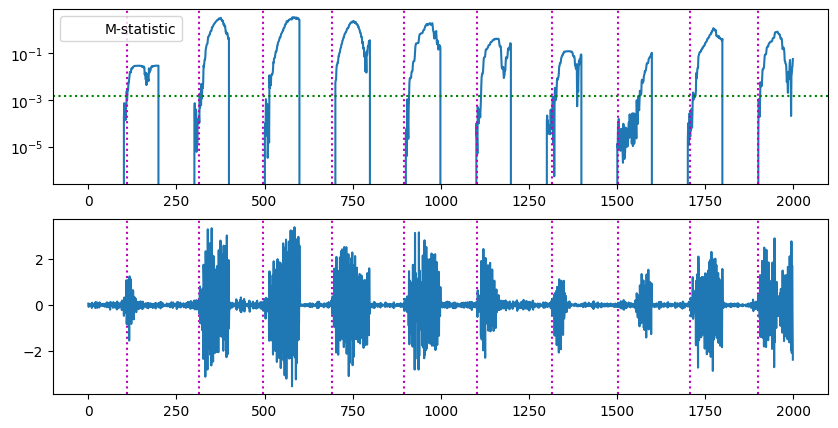

In [53]:
S_mmd = np.append(s_mmd_train, s_mmd_test)
f, ax = plt.subplots(2, 1, figsize=(10, 5))
ax[0].plot(S_mmd)
ax[0].set_yscale('log')
ax[0].axhline(z, c='g', ls=':')
for c in cps:
    ax[0].axvline(c, c='m', ls=':')
    ax[1].axvline(c, c='m', ls=':')
ax[0].plot(0, lw=0, label="M-statistic")
ax[1].plot(data_with_cps_for_plot)
ax[0].legend()
plt.show()
